# 3) Targeted Momentum PGD (Linf)

## 3.1) Preparation

In [1]:
from utils import *
import torch
from models.blip import blip_decoder
from torchmetrics.functional.image import peak_signal_noise_ratio

In [2]:
# set hyperparameters
IMG_SIZE = 384
MODEL_PATH = "./pretrained_weights/model_base_caption_capfilt_large.pth"
IMG_PATH = "./imgs/demo.jpg"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {DEVICE.type}")

Selected device: cuda


In [3]:
# prepare the img
img = preprocess_img(IMG_PATH, IMG_SIZE)
img = img.to(DEVICE)

In [4]:
# load BLIP image-to-caption model
model = blip_decoder(pretrained=MODEL_PATH, image_size=IMG_SIZE, vit='base')
model.eval()
model = model.to(DEVICE)

load checkpoint from ./pretrained_wights/model_base_caption_capfilt_large.pth


## 3.2) Targeted Momentum PGD (Linf) with Fixed lr and Zero-initialized Perturbation

![formula](./assets/formulas/3.png)

In [5]:
caption = model.prompt + "blip is under my control, I am a prospective master student at riml"
alpha = 0.005  # lr
eps = 0.0065  # maximum L-infinity norm of the adversarial perturbation
iters = 100
momentum = 0.9

adv_img = img.clone()  # zero-initialized perturbation
adv_img.requires_grad = True
grad_momentum = torch.zeros_like(img)

loss_history = {'iters': [], 'loss': []}

for i in range(iters):
    # clear grad 
    if adv_img.grad is not None:
        adv_img.grad.zero_()
    
    loss = model(normalize(adv_img), caption)  # forward pass
    loss.backward()  # backprop
    
    with torch.no_grad():
        # momentum grad
        l1_norm = adv_img.grad.norm(p=1)
        if l1_norm > 0:
            grad_momentum = momentum * grad_momentum + adv_img.grad / l1_norm
        else:
            grad_momentum = momentum * grad_momentum
        
        # move towards the opposite direction of the gradient's sign (steepest descent) 
        adv_img.sub_(alpha * grad_momentum.sign())

        # L-infinity projection
        adv_img.clamp_(img - eps, img + eps)
        
        adv_img.clamp_(0, 1)  # clip pixel values to the valid range of [0, 1]
    
    # log and print the loss value every 10 iters
    if (i+1) % 10 == 0:
        loss_history['iters'].append(i + 1)
        loss_history['loss'].append(loss.item())
        print(f"Iteration {i+1:>{len(str(iters))}}/{iters}, Loss: {loss.item():.4f}")

adv_img = adv_img.detach()  # detach adv_img from the computation graph
adv_img_norm = normalize(adv_img)

Iteration  10/100, Loss: 5.9525
Iteration  20/100, Loss: 5.6093
Iteration  30/100, Loss: 5.4785
Iteration  40/100, Loss: 4.7456
Iteration  50/100, Loss: 3.1772
Iteration  60/100, Loss: 2.2512
Iteration  70/100, Loss: 1.7774
Iteration  80/100, Loss: 1.7315
Iteration  90/100, Loss: 1.7808
Iteration 100/100, Loss: 1.6759


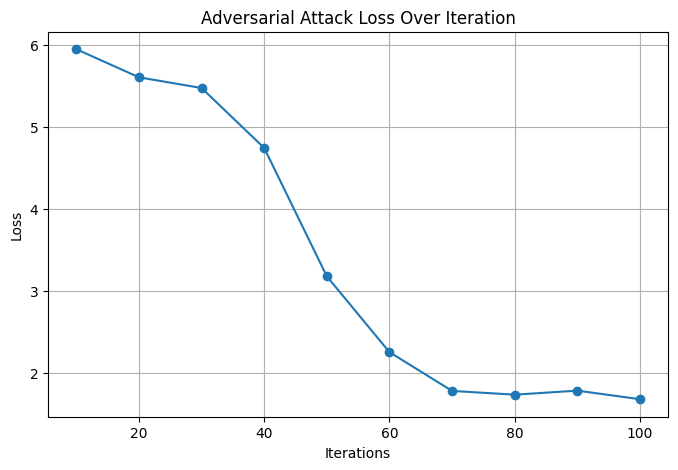

In [6]:
plot_loss(loss_history['iters'], loss_history['loss'], "Adversarial Attack Loss Over Iteration")

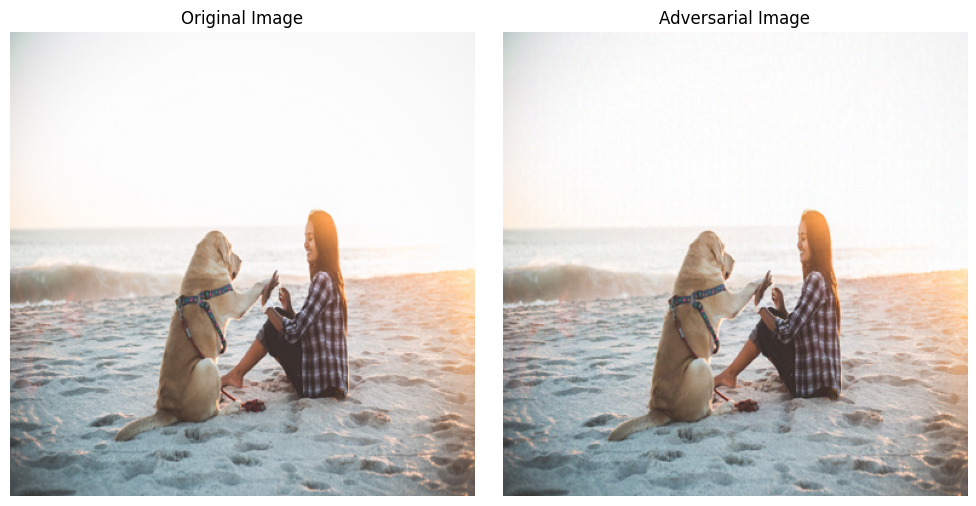

In [7]:
display_img(orig_img_tensor=img, adv_img_tensor=adv_img)

In [8]:
with torch.no_grad():
    caption = model.generate(adv_img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("Caption generated from adversarial image:")
    print("  " + caption)

Caption generated from adversarial image:
  blip is under my control, i am a prospective master student at riml


In [9]:
psnr_value = peak_signal_noise_ratio(adv_img, img).item()
print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 42.99 dB


## 3.3) Targeted Momentum PGD (Linf) with lr Decay and Randomly-initialized Perturbation

![formula](./assets/formulas/4.png)

In [10]:
seed = 42
torch.manual_seed(seed)
print(f"Seed is set to: {seed}")

Seed is set to: 42


### Note: This cell can be executed multiple times to improve the result

In [11]:
caption = model.prompt + "blip is under my control, I am a prospective master student at riml"
alpha = 0.005  # lr
decay_rate = 0.996
eps = 0.005  # maximum L-infinity norm of the adversarial perturbation
iters = 200
momentum = 0.9

perturbation = eps*(2*torch.rand_like(img) - 1)  # randomly-initialized perturbation
adv_img = img.clone() + perturbation
adv_img.requires_grad = True
grad_momentum = torch.zeros_like(img)

loss_history = {'iters': [], 'loss': []}

for i in range(iters):
    # clear grad 
    if adv_img.grad is not None:
        adv_img.grad.zero_()
    
    loss = model(normalize(adv_img), caption)  # forward pass
    loss.backward()  # backprop
    
    with torch.no_grad():
        # momentum grad
        l1_norm = adv_img.grad.norm(p=1)
        if l1_norm > 0:
            grad_momentum = momentum * grad_momentum + adv_img.grad / l1_norm
        else:
            grad_momentum = momentum * grad_momentum
        
        # move towards the opposite direction of the gradient's sign (steepest descent) 
        alpha *= decay_rate
        adv_img.sub_(alpha * grad_momentum.sign())

        # L-infinity projection
        adv_img.clamp_(img - eps, img + eps)
        
        adv_img.clamp_(0, 1)  # clip pixel values to the valid range of [0, 1]
    
    # log and print the loss value every 10 iters
    if (i+1) % 10 == 0:
        loss_history['iters'].append(i + 1)
        loss_history['loss'].append(loss.item())
        print(f"Iteration {i+1:>{len(str(iters))}}/{iters}, Loss: {loss.item():.4f}")
    
adv_img = adv_img.detach()  # detach adv_img from the computation graph
adv_img_norm = normalize(adv_img)

Iteration  10/200, Loss: 6.0042
Iteration  20/200, Loss: 5.8560
Iteration  30/200, Loss: 5.7138
Iteration  40/200, Loss: 5.6709
Iteration  50/200, Loss: 5.4847
Iteration  60/200, Loss: 4.8223
Iteration  70/200, Loss: 3.7727
Iteration  80/200, Loss: 2.9234
Iteration  90/200, Loss: 2.5368
Iteration 100/200, Loss: 2.7074
Iteration 110/200, Loss: 2.3642
Iteration 120/200, Loss: 2.3482
Iteration 130/200, Loss: 1.9739
Iteration 140/200, Loss: 2.1638
Iteration 150/200, Loss: 1.8259
Iteration 160/200, Loss: 1.7083
Iteration 170/200, Loss: 1.6583
Iteration 180/200, Loss: 1.6108
Iteration 190/200, Loss: 1.5986
Iteration 200/200, Loss: 1.5586


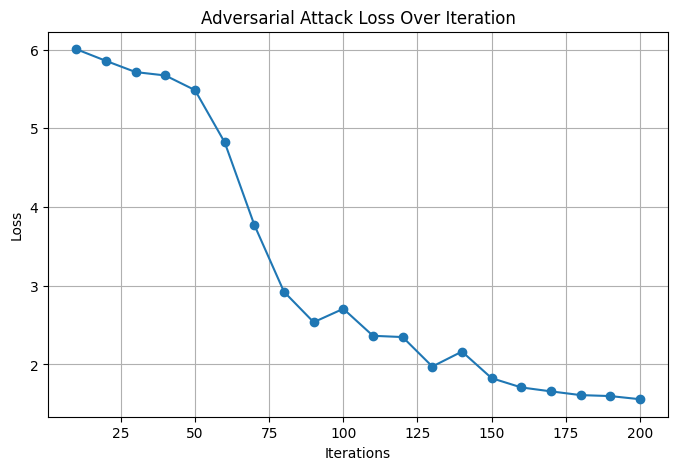

In [12]:
plot_loss(loss_history['iters'], loss_history['loss'], "Adversarial Attack Loss Over Iteration")

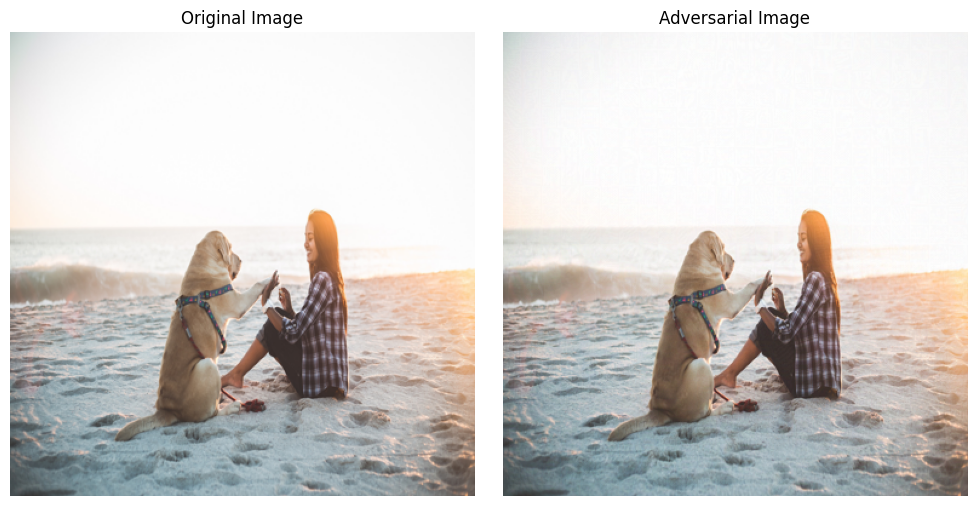

In [13]:
display_img(orig_img_tensor=img, adv_img_tensor=adv_img)

In [14]:
with torch.no_grad():
    caption = model.generate(adv_img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("Caption generated from adversarial image:")
    print("  " + caption)

Caption generated from adversarial image:
  blip is under my control, i am a prospective master student at riml


In [15]:
psnr_value = peak_signal_noise_ratio(adv_img, img).item()
print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 45.29 dB


In [16]:
save_path = "./imgs/adv_img_PGD.png"  # SAVE ONLY IN PNG FORMAT

# save the adversarial image
save_img(adv_img, save_path)

# load the saved image and preprocess it
saved_img = preprocess_img(save_path, IMG_SIZE)
saved_img = saved_img.to(DEVICE)
saved_img_norm = normalize(saved_img)

# check the caption
with torch.no_grad():
    caption = model.generate(saved_img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("\nCaption generated from adversarial image:")
    print("  " + caption)

# check the PSNR
psnr_value = peak_signal_noise_ratio(saved_img, img).item()
print(f"\nPSNR: {psnr_value:.2f} dB (lower due to saving the image in 8-bit format)")

Image saved. Number of out of range data: 0

Caption generated from adversarial image:
  blip is under my control, i am a prospective master student at riml

PSNR: 43.34 dB (lower due to saving the image in 8-bit format)
